In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals


In [ ]:
#Importing Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [ ]:
physical_devices=tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices)>0:
    tf.config.experimental.set_memory_growth(physical_devices[0],True)
    print("GPU is being used")
else:
    print("GPU is not being used")

GPU is being used


In [ ]:
#Path of the dataset
dataset_path="/kaggle/input/animal-image-dataset-90-different-animals/animals/animals"

# List of the animal types
classes=os.listdir(dataset_path)
num_classes=len(classes)
print("Classes",classes)
print("Number od Classes",num_classes)

Classes ['beetle', 'parrot', 'fox', 'wolf', 'hedgehog', 'turtle', 'snake', 'shark', 'horse', 'antelope', 'hamster', 'woodpecker', 'eagle', 'chimpanzee', 'bison', 'penguin', 'butterfly', 'sandpiper', 'hornbill', 'lion', 'lobster', 'oyster', 'otter', 'grasshopper', 'raccoon', 'dog', 'pigeon', 'donkey', 'hippopotamus', 'hummingbird', 'bear', 'coyote', 'bee', 'pig', 'rat', 'owl', 'caterpillar', 'koala', 'squid', 'hare', 'whale', 'mouse', 'tiger', 'fly', 'lizard', 'orangutan', 'bat', 'porcupine', 'kangaroo', 'gorilla', 'starfish', 'mosquito', 'crow', 'possum', 'goldfish', 'swan', 'elephant', 'sheep', 'dragonfly', 'zebra', 'seal', 'octopus', 'cow', 'ox', 'wombat', 'reindeer', 'panda', 'duck', 'goose', 'goat', 'badger', 'flamingo', 'crab', 'seahorse', 'rhinoceros', 'dolphin', 'okapi', 'moth', 'sparrow', 'pelecaniformes', 'squirrel', 'leopard', 'jellyfish', 'ladybugs', 'cockroach', 'hyena', 'cat', 'deer', 'turkey', 'boar']
Number od Classes 90


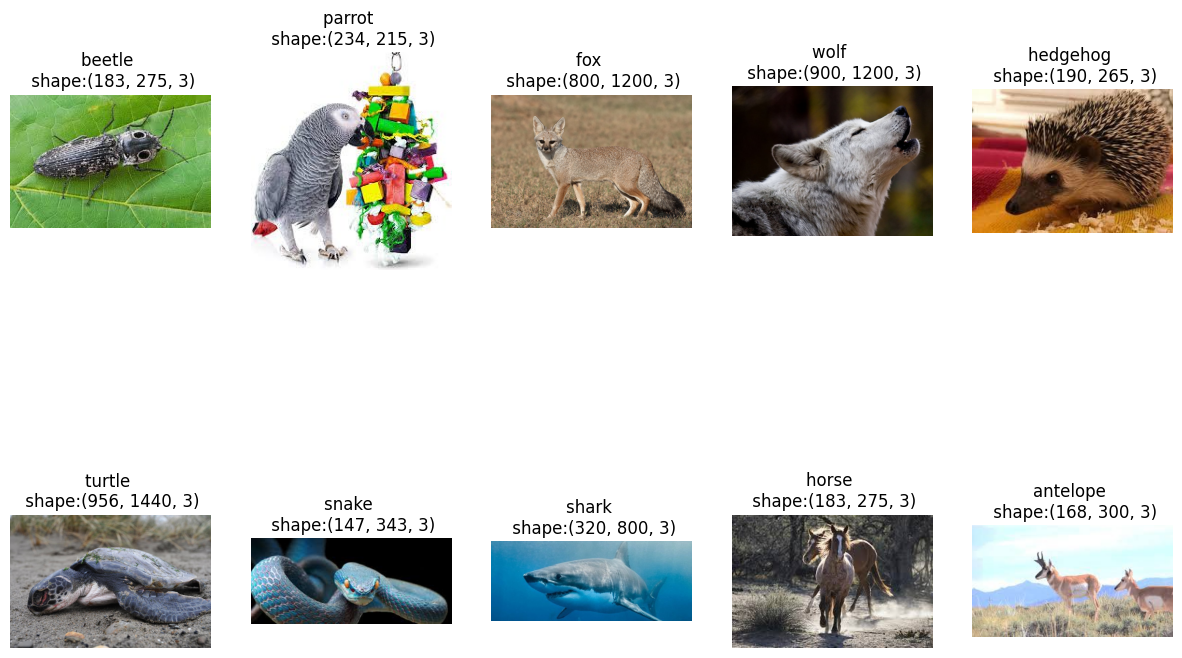

In [ ]:
#Visulalize some sample images from the database
plt.figure(figsize=(15,10))
for i,class_name in enumerate(classes[:10]):
  class_path=os.path.join(dataset_path,class_name)
  img_name=os.listdir(class_path)[0]
  img_path=os.path.join(class_path,img_name)
  img=plt.imread(img_path)
  plt.subplot(2,5,i+1)
  plt.imshow(img)
  plt.title(f'{class_name} \n shape:{img.shape}')
  plt.axis('off')
plt.show()

In [ ]:
# Preprocessing the data.
# Define image size and batch_size - Trained model - MobileNetV2 - 224 x 224
img_size = (224, 224)
batch_size = 64 # There can be 64 images in a batch

# Data Augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

# Create training and validation generators
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 4860 images belonging to 90 classes.
Found 540 images belonging to 90 classes.


In [ ]:
# Map the classes - class_indices
class_indices = train_generator.class_indices
print(class_indices)
# Extract class names
class_names = list(class_indices.keys())
print("Class Names:", class_names)

{'antelope': 0, 'badger': 1, 'bat': 2, 'bear': 3, 'bee': 4, 'beetle': 5, 'bison': 6, 'boar': 7, 'butterfly': 8, 'cat': 9, 'caterpillar': 10, 'chimpanzee': 11, 'cockroach': 12, 'cow': 13, 'coyote': 14, 'crab': 15, 'crow': 16, 'deer': 17, 'dog': 18, 'dolphin': 19, 'donkey': 20, 'dragonfly': 21, 'duck': 22, 'eagle': 23, 'elephant': 24, 'flamingo': 25, 'fly': 26, 'fox': 27, 'goat': 28, 'goldfish': 29, 'goose': 30, 'gorilla': 31, 'grasshopper': 32, 'hamster': 33, 'hare': 34, 'hedgehog': 35, 'hippopotamus': 36, 'hornbill': 37, 'horse': 38, 'hummingbird': 39, 'hyena': 40, 'jellyfish': 41, 'kangaroo': 42, 'koala': 43, 'ladybugs': 44, 'leopard': 45, 'lion': 46, 'lizard': 47, 'lobster': 48, 'mosquito': 49, 'moth': 50, 'mouse': 51, 'octopus': 52, 'okapi': 53, 'orangutan': 54, 'otter': 55, 'owl': 56, 'ox': 57, 'oyster': 58, 'panda': 59, 'parrot': 60, 'pelecaniformes': 61, 'penguin': 62, 'pig': 63, 'pigeon': 64, 'porcupine': 65, 'possum': 66, 'raccoon': 67, 'rat': 68, 'reindeer': 69, 'rhinoceros': 

In [ ]:
# Load MobileNetV2 as the base model
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model weights, training
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x) # output layer

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
# Model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,661,978 (13.97 MB)

 Trainable params: 1,403,994 (5.36 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs = 20
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 83s 936ms/step - accuracy: 0.0468 - loss: 4.5782 - val_accuracy: 0.4922 - val_loss: 3.3004
Epoch 2/20
 1/75 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.2969 - loss: 3.5237

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.2969 - loss: 3.5237 - val_accuracy: 0.5059 - val_loss: 3.2799
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 40s 530ms/step - accuracy: 0.4060 - loss: 2.9987 - val_accuracy: 0.7168 - val_loss: 1.9266
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.4844 - loss: 2.4035 - val_accuracy: 0.7266 - val_loss: 1.8818
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 538ms/step - accuracy: 0.6518 - loss: 1.7667 - val_accuracy: 0.7656 - val_loss: 1.2462
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6406 - loss: 1.6236 - val_accuracy: 0.7656 - val_loss: 1.2337
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 573ms/step - accuracy: 0.7490 - loss: 1.1790 - val_accuracy: 0.7969 - val_loss: 0.9726
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.6406 - loss: 1.2572 - val_accuracy: 0.7930 - val_loss: 0.9744
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 36s 480ms/step - accuracy: 0.7968 - loss: 0.8777 - val_accuracy: 0.8105 - val_

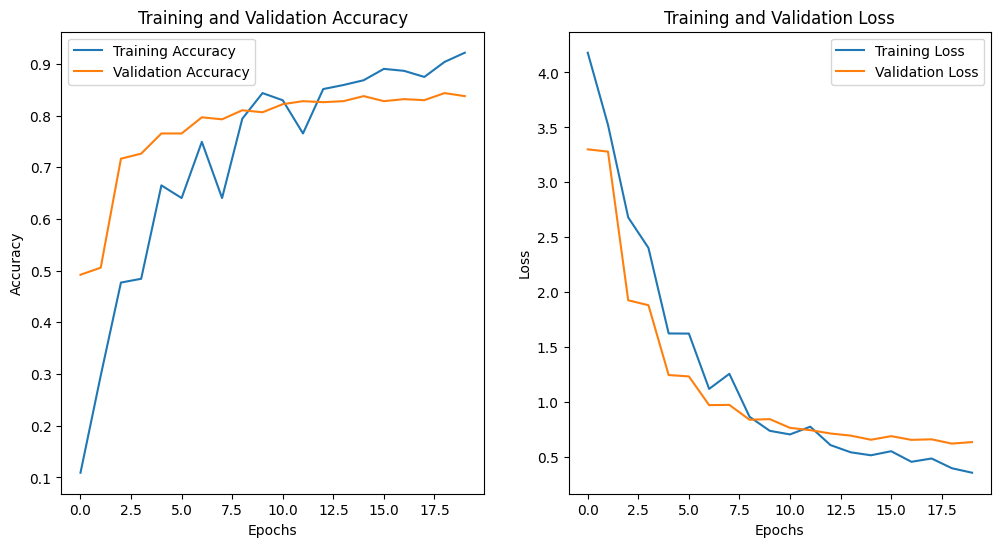

In [ ]:
# Evaluate the model - plotting the training and validation acc/loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 814ms/step - accuracy: 0.8401 - loss: 0.6426
Validation Loss: 0.6290869116783142
Validation Accuracy: 0.8388888835906982


In [ ]:
# Save the model
model.save('MCAR.keras')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model('MCAR.keras')

def predict_animal(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

In [ ]:
os.listdir('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/parrot')

['5affc48d37.jpg',
 '4aba5914cd.jpg',
 '3ac69be3f6.jpg',
 '29c26708a0.jpg',
 '96c5e35a54.jpg',
 '60e0c50a4a.jpg',
 '27a9ce4e1a.jpg',
 '64bd254fef.jpg',
 '46ed4828b1.jpg',
 '3a0c5d4582.jpg',
 '6a0ab0de34.jpg',
 '84b6622dbc.jpg',
 '6be2eb3fb3.jpg',
 '1bcd666a4e.jpg',
 '87bc6bdcd7.jpg',
 '1b9f359f9c.jpg',
 '62fc818264.jpg',
 '7a7fdb0450.jpg',
 '9d0d266d23.jpg',
 '8f5a2730b3.jpg',
 '4c26cd72e2.jpg',
 '4faf55514e.jpg',
 '2f207b75e3.jpg',
 '56b19e9dbc.jpg',
 '1dd93e1004.jpg',
 '66e79b1a2f.jpg',
 '34f9668c8e.jpg',
 '3de507dbb6.jpg',
 '0b29c10342.jpg',
 '64c08f053c.jpg',
 '060cca8826.jpg',
 '036b760476.jpg',
 '46c1b71d00.jpg',
 '8cdc657d99.jpg',
 '61def3553e.jpg',
 '0100ec7408.jpg',
 '8a8a69d934.jpg',
 '7d5cb5f5fa.jpg',
 '47ef39ceb6.jpg',
 '7dab3a1142.jpg',
 '46de4406fb.jpg',
 '6a184a05f3.jpg',
 '89d679b9e5.jpg',
 '0f072e6ce1.jpg',
 '0d778c6833.jpg',
 '0b2a1e349a.jpg',
 '3f5e9e225b.jpg',
 '4af25ae32d.jpg',
 '1cabf8a760.jpg',
 '5b1030ddd5.jpg',
 '91f0604cc7.jpg',
 '080a286cf3.jpg',
 '50e40b5356

In [ ]:
['5affc48d37.jpg',
 '4aba5914cd.jpg',
 '3ac69be3f6.jpg',
 '29c26708a0.jpg',
 '96c5e35a54.jpg',
 '60e0c50a4a.jpg',
 '27a9ce4e1a.jpg',
 '64bd254fef.jpg',
 '46ed4828b1.jpg',
 '3a0c5d4582.jpg',
 '6a0ab0de34.jpg',
 '84b6622dbc.jpg',
 '6be2eb3fb3.jpg',
 '1bcd666a4e.jpg',
 '87bc6bdcd7.jpg',
 '1b9f359f9c.jpg',
 '62fc818264.jpg',
 '7a7fdb0450.jpg',
 '9d0d266d23.jpg',
 '8f5a2730b3.jpg',
 '4c26cd72e2.jpg',
 '4faf55514e.jpg',
 '2f207b75e3.jpg',
 '56b19e9dbc.jpg',
 '1dd93e1004.jpg',
 '66e79b1a2f.jpg',
 '34f9668c8e.jpg',
 '3de507dbb6.jpg',
 '0b29c10342.jpg',
 '64c08f053c.jpg',
 '060cca8826.jpg',
 '036b760476.jpg',
 '46c1b71d00.jpg',
 '8cdc657d99.jpg',
 '61def3553e.jpg',
 '0100ec7408.jpg',
 '8a8a69d934.jpg',
 '7d5cb5f5fa.jpg',
 '47ef39ceb6.jpg',
 '7dab3a1142.jpg',
 '46de4406fb.jpg',
 '6a184a05f3.jpg',
 '89d679b9e5.jpg',
 '0f072e6ce1.jpg',
 '0d778c6833.jpg',
 '0b2a1e349a.jpg',
 '3f5e9e225b.jpg',
 '4af25ae32d.jpg',
 '1cabf8a760.jpg',
 '5b1030ddd5.jpg',
 '91f0604cc7.jpg',
 '080a286cf3.jpg',
 '50e40b5356.jpg',
 '4ead913624.jpg',
 '25e773e479.jpg',
 '5d18e7e995.jpg',
 '47d00fc79f.jpg',
 '1f4f736dbf.jpg',
 '9c2dd51734.jpg',
 '7b8d54f49e.jpg']

['5affc48d37.jpg',
 '4aba5914cd.jpg',
 '3ac69be3f6.jpg',
 '29c26708a0.jpg',
 '96c5e35a54.jpg',
 '60e0c50a4a.jpg',
 '27a9ce4e1a.jpg',
 '64bd254fef.jpg',
 '46ed4828b1.jpg',
 '3a0c5d4582.jpg',
 '6a0ab0de34.jpg',
 '84b6622dbc.jpg',
 '6be2eb3fb3.jpg',
 '1bcd666a4e.jpg',
 '87bc6bdcd7.jpg',
 '1b9f359f9c.jpg',
 '62fc818264.jpg',
 '7a7fdb0450.jpg',
 '9d0d266d23.jpg',
 '8f5a2730b3.jpg',
 '4c26cd72e2.jpg',
 '4faf55514e.jpg',
 '2f207b75e3.jpg',
 '56b19e9dbc.jpg',
 '1dd93e1004.jpg',
 '66e79b1a2f.jpg',
 '34f9668c8e.jpg',
 '3de507dbb6.jpg',
 '0b29c10342.jpg',
 '64c08f053c.jpg',
 '060cca8826.jpg',
 '036b760476.jpg',
 '46c1b71d00.jpg',
 '8cdc657d99.jpg',
 '61def3553e.jpg',
 '0100ec7408.jpg',
 '8a8a69d934.jpg',
 '7d5cb5f5fa.jpg',
 '47ef39ceb6.jpg',
 '7dab3a1142.jpg',
 '46de4406fb.jpg',
 '6a184a05f3.jpg',
 '89d679b9e5.jpg',
 '0f072e6ce1.jpg',
 '0d778c6833.jpg',
 '0b2a1e349a.jpg',
 '3f5e9e225b.jpg',
 '4af25ae32d.jpg',
 '1cabf8a760.jpg',
 '5b1030ddd5.jpg',
 '91f0604cc7.jpg',
 '080a286cf3.jpg',
 '50e40b5356

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


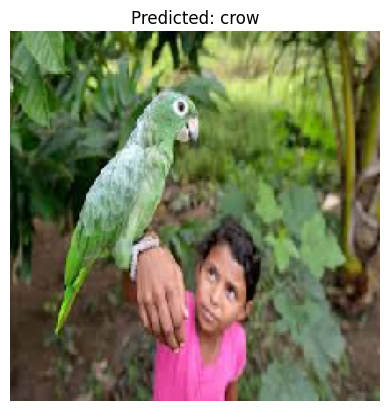

In [ ]:
predict_animal('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/parrot/0100ec7408.jpg')